Processing rows for num_bins = 3500: 100%|██████████████████████████████████████| 2986/2986 [00:00<00:00, 11642.10it/s]


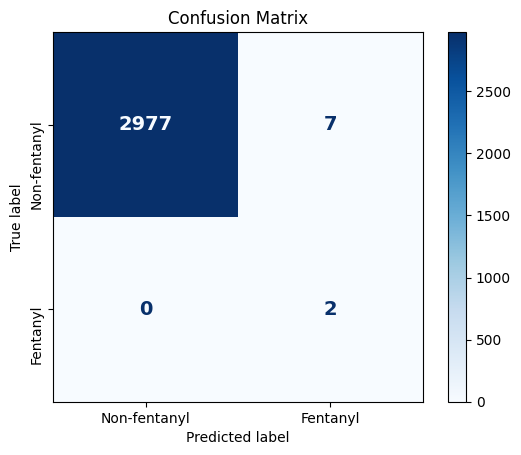

In [6]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve, auc, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best model
best_rf_model = joblib.load('Fentanyl_Finder.pkl')

# Read the data
data = pd.read_excel("Urine_addition_example.xlsx")
data['MSMS spectrum'] = data['MSMS spectrum'].apply(lambda x: x.split('\n'))

# Define parameters
ms2int_threshold = 10.0
mz_min = 50.0
mz_max = 400.0
num_bins = 3500

# Data preprocessing
data_processed = data.copy()

# Initialize the m/z bins matrix
mz_bins_matrix = np.zeros((len(data_processed), num_bins))

for i, row in tqdm(enumerate(data_processed.itertuples()), total=len(data_processed), desc=f"Processing rows for num_bins = {num_bins}"):
    MS2_list = row.spectral
    mz = []
    Relative_int = []
    for pair in MS2_list:
        if pair:
            try:
                mz_val, intensity_val = pair.split()
                mz.append(float(mz_val))
                Relative_int.append(float(intensity_val))
            except ValueError:
                continue

    filtered_pairs = [(mz_val, int_val) for mz_val, int_val in zip(mz, Relative_int) if int_val >= ms2int_threshold and mz_min <= mz_val <= mz_max]
    for mz_val, int_val in filtered_pairs:
        bin_index = int((mz_val - mz_min) / (mz_max - mz_min) * num_bins)
        bin_index = max(0, min(bin_index, num_bins - 1))
        mz_bins_matrix[i, bin_index] += int_val

# Convert the m/z bins matrix to a DataFrame and merge it with data_processed
mz_bins_df = pd.DataFrame(mz_bins_matrix, columns=[f'bin_{i}' for i in range(num_bins)])
data_processed = pd.concat([data_processed.reset_index(drop=True), mz_bins_df.reset_index(drop=True)], axis=1)

# Drop the original 'spectral' column
data_processed.drop('MSMS spectrum', axis=1, inplace=True)

# Separate features and labels
X = data_processed.drop(['Fentanyl', 'PeakID', 'Fentanyl'], axis=1)
y_true = data_processed['Fentanyl']

# Make predictions
y_pred = best_rf_model.predict(X)
y_proba = best_rf_model.predict_proba(X)[:, 1]

# Evaluate the model
conf_matrix = confusion_matrix(y_true, y_pred)

# Define a function to plot the confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-fentanyl", "Fentanyl"])
    
    # Plot the confusion matrix
    fig, ax = plt.subplots()
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    
    # Modify the title
    plt.title(title)
    
    # Bold and enlarge the numbers on the plot
    for text in ax.texts:
        text.set_fontsize(14)
        text.set_fontweight('bold')
    
    # Rotate the y-axis labels vertically
    ax.yaxis.set_tick_params(labelrotation=90)

# Plot the confusion matrix
plot_conf_matrix(y_true, y_pred, 'Confusion Matrix')

# Add the prediction results as new columns in the table
data_processed['Predicted Label'] = y_pred
data_processed['Prediction Probability'] = y_proba

# Export the results to a new CSV file
output_file = "Class.csv"
data_processed.to_csv(output_file, index=False)
